## Training our model
Here we create a same architecture model of our keras model in tensorflow and train it.
Hence we get a accuracy of 99.05% on test samples.

In [1]:
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')          
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
img_size = 28
img_chan = 1
n_classes = 10

In [2]:
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')          
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf



img_size = 28
img_chan = 1
n_classes = 10


print('\nLoading MNIST')

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]

print('\nConstruction graph')


def model(x, logits=False, training=False):
    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[4, 4],
                             padding='VALID', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[4, 4],
                             padding='Valid', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('mlp'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.3, training=training)

    logits_ = tf.layers.dense(z, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y

class Dummy:
    pass


env = Dummy()


with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan),
                           name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.reduce_mean(xent, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.train.Saver()



print('\nInitializing graph')

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())


def evaluate(sess, env, X_data, y_data, batch_size=128):
    """
    Evaluate TF model by running env.loss and env.acc.
    """
    print('\nEvaluating')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc


def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    """
    Train a TF model by running env.train_op.
    """
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(sess, 'model/{}'.format(name))

    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(sess, 'model/{}'.format(name))


def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
    print()
    return yval


'''def make_fgmt(sess, env, X_data, epochs=1, eps=0.01, batch_size=128):
    """
    Generate FGSM by running env.x_fgsm.
    """
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        adv = sess.run(env.x_fgmt, feed_dict={
            env.x: X_data[start:end],
            env.fgsm_eps: eps,
            env.fgsm_epochs: epochs})
        X_adv[start:end] = adv
    print()

    return X_adv'''


print('\nTraining')

train(sess, env, X_train, y_train, X_valid, y_valid, load=False, epochs=5,
      name='mnist')

print('\nEvaluating on clean data')

evaluate(sess, env, X_test, y_test)




Loading MNIST

Spliting data

Construction graph
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Initializing graph

Training

Train model

Epoch 1/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0708 acc: 0.9778

Epoch 2/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0492 acc: 0.9847

Epoch 3/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0412 acc: 0.9875

Epoch 4/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0342 acc: 0.9900

Epoch 5/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0317 acc: 0.9913

 Saving model

Evaluating on clean data

Evaluating
 loss: 0.0272 acc: 0.9905


(0.027207904791785403, 0.9905)

# Fast gradient method attack


In [3]:
import tensorflow as tf


def fgm(model, x, eps=0.01, epochs=1, sign=True, clip_min=0., clip_max=1.):
    """
    Fast gradient method.
    :param model: A wrapper that returns the output as well as logits.
    :param x: The input placeholder.
    :param eps: The scale factor for noise.
    :param epochs: The maximum epoch to run.
    :param sign: Use gradient sign if True, otherwise use gradient value.
    :param clip_min: The minimum value in output.
    :param clip_max: The maximum value in output.
    :return: A tensor, contains adversarial samples for each input.
    """
    xadv = tf.identity(x)

    ybar = model(xadv)
    yshape = ybar.get_shape().as_list()
    ydim = yshape[1]

    indices = tf.argmax(ybar, axis=1)
    target = tf.cond(
        tf.equal(ydim, 1),
        lambda: tf.nn.relu(tf.sign(ybar - 0.5)),
        lambda: tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0))

    if 1 == ydim:
        loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.nn.softmax_cross_entropy_with_logits

    if sign:
        noise_fn = tf.sign
    else:
        noise_fn = tf.identity

    eps = tf.abs(eps)

    def _cond(xadv, i):
        return tf.less(i, epochs)

    def _body(xadv, i):
        ybar, logits = model(xadv, logits=True)
        loss = loss_fn(labels=target, logits=logits)
        dy_dx, = tf.gradients(loss, xadv)
        xadv = tf.stop_gradient(xadv + eps*noise_fn(dy_dx))
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.while_loop(_cond, _body, (xadv, 0), back_prop=False,
                            name='fast_gradient')
    return xadv




In [8]:
with tf.variable_scope('model', reuse=True):
    env.fgsm_eps = tf.placeholder(tf.float32, (), name='fgsm_eps')
    env.fgsm_epochs = tf.placeholder(tf.int32, (), name='fgsm_epochs')
    env.x_fgmt = fgm(model, env.x, epochs=env.fgsm_epochs, eps=env.fgsm_eps)

# Creating Adversial Images

Here we create and test the adversial images created on our model. The accuracy achieved after running the model on adversial images the accuracy achieved is 7% which states our attack was pretty much sucessful.

In [9]:
def make_fgmt(sess, env, X_data, epochs=1, eps=0.01, batch_size=128):
    """
    Generate FGSM by running env.x_fgsm.
    """
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        adv = sess.run(env.x_fgmt, feed_dict={
            env.x: X_data[start:end],
            env.fgsm_eps: eps,
            env.fgsm_epochs: epochs})
        X_adv[start:end] = adv
    print()

    return X_adv

print('\nGenerating adversarial data')

X_adv = make_fgmt(sess, env, X_test, eps=0.02, epochs=12)

print('\nEvaluating on adversarial data')

evaluate(sess, env, X_adv, y_test)

print('\nRandomly sample adversarial data from each category')

y1 = predict(sess, env, X_test)
y2 = predict(sess, env, X_adv)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))
for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0 == i, z1 == i, z2 != i], axis=0))
    cur = np.random.choice(ind)
    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]




Generating adversarial data

Making adversarials via FGSM
 batch 79/79

Evaluating on adversarial data

Evaluating
 loss: 5.4613 acc: 0.0768

Randomly sample adversarial data from each category

Predicting
 batch 79/79

Predicting
 batch 79/79
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9


In [ ]:
import os
os.getcwd()

In [10]:
print('\nPlotting results')

fig = plt.figure(figsize=(10, 1.2))
gs = gridspec.GridSpec(1, 10, wspace=0.05, hspace=0.05)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')

gs.tight_layout(fig)
#os.makedirs('img', exist_ok=True)
plt.savefig('fgm_mnist.jpg')


Plotting results

Saving figure


# Results
The images below shows us the first 10 images of 10 different classes. Below the images we can see the Label predicted and its likelihood.

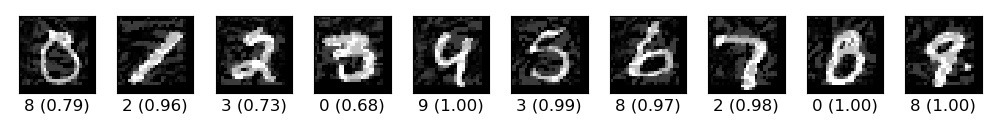
